In [7]:
### import modules
import numpy as np
from utils import plot_scenarios, run_modified_seir, seir

# Exploring Scenarios
In order to explore regimes in which the two different vaccine failure mechanisms result in a significant difference, we quantified the impact of vaccine failure using the total recovered population. For each of the three vaccination scenarios (pre-transmission, 10 days post-transmission, 30 days post-transmission), the $R_0$ values were varied from 1.0 to 3.0, vaccine efficacy was varied from 1% effective to 100% effective, and for each $R_0$ value and vaccine efficacy, we used three different vaccination population values - below, slightly above, and above the critical vaccination level. Note that the $R_0$ values used are the values before intervention.

## Critical Vaccination Threshold ($f_V^*$)
The critical vaccinated threshold refers to the proportion of the population that must be vaccinated in order to reach herd immunity, preventing further transmission of the disease. This value depends on how fast the disease spreads and how effective the vaccine is, as more people would need to get vaccinated if the disease had a high $R_0$ value and low vaccine efficacy. Note that the critical vaccination level cannot exceed 1.

Recall that for this model, $R_{0,V} = R_0 (1 - \epsilon_L \epsilon_A f_V)$. From this, we can define the critical vaccination threshold as:

$$ f^*_V = \frac{1}{\epsilon_L \epsilon_A} (1 - \frac{1}{R_0}) $$

if vaccination occurs before the epidemic begins.

If vaccination occurs after the epidemic has begun, a fraction $f_R$ has already been infected are immune to reinfection. Thus, assuming an instantaneous vaccine campaign that targets only susceptible individuals,

$$ f^*_V = \frac{1}{\epsilon_L \epsilon_A} (1 - \frac{1}{R_0(1 - f_R)})$$

Furthermore, to investigate regimes where vaccination is insufficient, minimally sufficient, and exceedingly sufficient, we will compare vaccination compaigns that reach three different levels of vaccine coverage relative to $f^*_V$ as follows:

$$ f_{V, \text{below}} = 0.8f^*_V $$
$$ f_{V, \text{slightly above}} =  1 - 0.8(1 - f^*_V) $$
$$ f_{V, \text{above}} = 1 - 0.5(1 - f^*_V) $$

We then calculated the percentage reduction of the total recovered population compared to that of without vaccination by 

$$ P = \frac{R - R_V}{R} \times 100 \, (\%)$$

where $R$ is the normalized total recovered population without vaccination and $R_V$ is the normalized total recovered population with vaccination through a 'leaky' or 'all-or-nothing' vaccine.

We then found the difference in percentage reduction between the two vaccine failure mechanisms by subtracting $P_L$ from $P_A$ because the 'all-or-nothing' vaccine always performed better than the 'leaky' vaccine.

The simulation was run with the following parameter values and initial conditions: $\gamma = 1/4$, $\sigma=1/4$, $S(0) = 0.98$, $E(0) = 0.01$, $I(0) = 0.01$, $R(0) = 0$, and the difference was measured at 30 days after vaccination, 60 days after vaccination, 150 days after vaccination, and the end of the modeled pandemic (at 300 days). 

In [6]:
import pandas as pd
from scipy.integrate import odeint

In [25]:
def modified_seir(y, t, beta, sigma, gamma, epsL):
    """
    Modified SEIR model for instantaneous vaccination. 
    """
    s, vs, vr, e, i, r = y
    
    dsdt = - beta*s*i
    dvsdt = - beta*vs*i
    dvrdt = - beta*(1-epsL)*vr*i
    dedt = beta*(s+vs+(1-epsL)*vr)*i - sigma*e
    didt = sigma*e - gamma*i
    drdt = gamma*i

    return dsdt, dvsdt, dvrdt, dedt, didt, drdt

In [26]:
def run_modified_seir(y0: list, t: int, tv: int, beta: float, sigma: float, gamma: float, fv: float, \
    eps: float, mode: str = 'leaky'):
    s0, e0, i0, r0 = y0
    if mode == 'leaky':
        epsL = eps; epsA = 1
    elif mode == 'aon':
        epsL = 1; epsA = eps
    else:
        print("Mode must be 'leaky' or 'aon'.")
    
    if tv == -1:
        vs0 = fv*(1-epsA)*s0; vr0 = fv*epsA*s0; s0_vax = s0*(1-fv)
        y0_vax = [s0_vax, vs0, vr0, e0, i0, r0]
        sim_vax = odeint(modified_seir, y0_vax, np.linspace(0, t, t+1), args=(beta, sigma, gamma, epsL))
        s_vax, vs, vr, e_vax, i_vax, r_vax = sim_vax.T
        v = vs + vr

        return s_vax, vs, vr, v, e_vax, i_vax, r_vax
    
    else:
        sim = odeint(seir, y0, np.linspace(0, tv, tv+1), args=(beta, sigma, gamma))
        s, e, i, r = sim.T

        vs0 = (1-epsA)*fv*s[-1]; vr0 = epsA*fv*s[-1]; s0_vax = s[-1]*(1-fv)
        y0_vax = [s0_vax, vs0, vr0, e[-1], i[-1], r[-1]]
        sim_vax = odeint(modified_seir, y0_vax, np.linspace(0, t-tv, t-tv+1), args=(beta, sigma, gamma, epsL))
        s_vax, vs, vr, e_vax, i_vax, r_vax = sim_vax.T
        v = vs + vr

        s_vax = np.concatenate((s[:-1], s_vax), axis=None)
        vs = np.concatenate((np.zeros(np.shape(s[:-1])), vs), axis=None)
        vr = np.concatenate((np.zeros(np.shape(s[:-1])), vr), axis=None)
        v = np.concatenate((np.zeros(np.shape(s[:-1])), v), axis=None)
        e_vax = np.concatenate((e[:-1], e_vax), axis=None)
        i_vax = np.concatenate((i[:-1], i_vax), axis=None)
        r_vax = np.concatenate((r[:-1], r_vax), axis=None)
    
        return s_vax, vs, vr, v, e_vax, i_vax, r_vax

In [27]:
def run_scenarios(y0: list, t: int, tv: int, R0s: np.ndarray, sigma: float, gamma: float, epss: np.ndarray):  
    s0, e0, i0, r0 = y0
    df_R0s = []; df_epss = []; df_fvs = []
    covs = ['Below fc', 'Slightly Above fc', 'Above fc']; df_covs = []
    df_r_perc_leakys = []; df_r_perc_aons = []; df_r_perc_diffs = []

    for R0 in R0s:
        beta = R0 * gamma
        sim = odeint(seir, y0, np.linspace(0, t, t+1), args=(beta, sigma, gamma))
        _, _, _, r = sim.T
        
        r_tot = r[-1]
                
        for eps in epss:
            if tv == -1:
                fc = 1/eps * (1 - 1/R0)
            else:
                sim_temp = odeint(seir, y0, np.linspace(0, tv, tv+1), args=(beta, sigma, gamma))
                s_temp, _, _, _ = sim_temp.T
                fc = 1/eps * (1 - 1/(R0*s_temp[-1]))
                
            for cov in covs:
                if cov == 'Below fc':
                    fv = fc * 0.8
                elif cov == 'Slightly Above fc':
                    fv = 1 - ((1 - fc) * 0.8)
                else:
                    fv = 1 - ((1 - fc) * 0.5)

                if fv < 0:
                    fv = 0
                elif fv > 0.98:
                    fv = 0.98
                else:
                    fv = fv
                
                _, _, _, _, _, _, r_leaky = run_modified_seir(y0, t, tv, beta, sigma, gamma, fv, eps, mode='leaky')
                _, _, _, _, _, _, r_aon = run_modified_seir(y0, t, tv, beta, sigma, gamma, fv, eps, mode='aon')

                r_perc_leaky = (r[-1] - r_leaky[-1]) / r[-1] * 100
                r_perc_aon = (r[-1] - r_aon[-1]) / r[-1] * 100
                r_perc_diff = r_perc_aon - r_perc_leaky

                df_R0s.append(R0)
                df_epss.append(eps)
                df_fvs.append(fv)
                df_covs.append(cov)
                df_r_perc_leakys.append(r_perc_leaky)
                df_r_perc_aons.append(r_perc_aon)
                df_r_perc_diffs.append(r_perc_diff)

    # build dataframe                        
    data = {'R0': df_R0s, 'VE': df_epss, 'Vax Coverage': df_covs, 'fv': df_fvs, \
        'Leaky': df_r_perc_leakys, 'AON': df_r_perc_aons, 'Diff': df_r_perc_diffs}
    vax_df = pd.DataFrame(data=data)

    return vax_df

# Measured 30 Days After Vaccination

/Users/dianelee/Documents/Github/vaccine-efficacy/VaccineEfficacy/utils/utils.py:405: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(np.round(np.exp(cblabels)-1).astype(int))


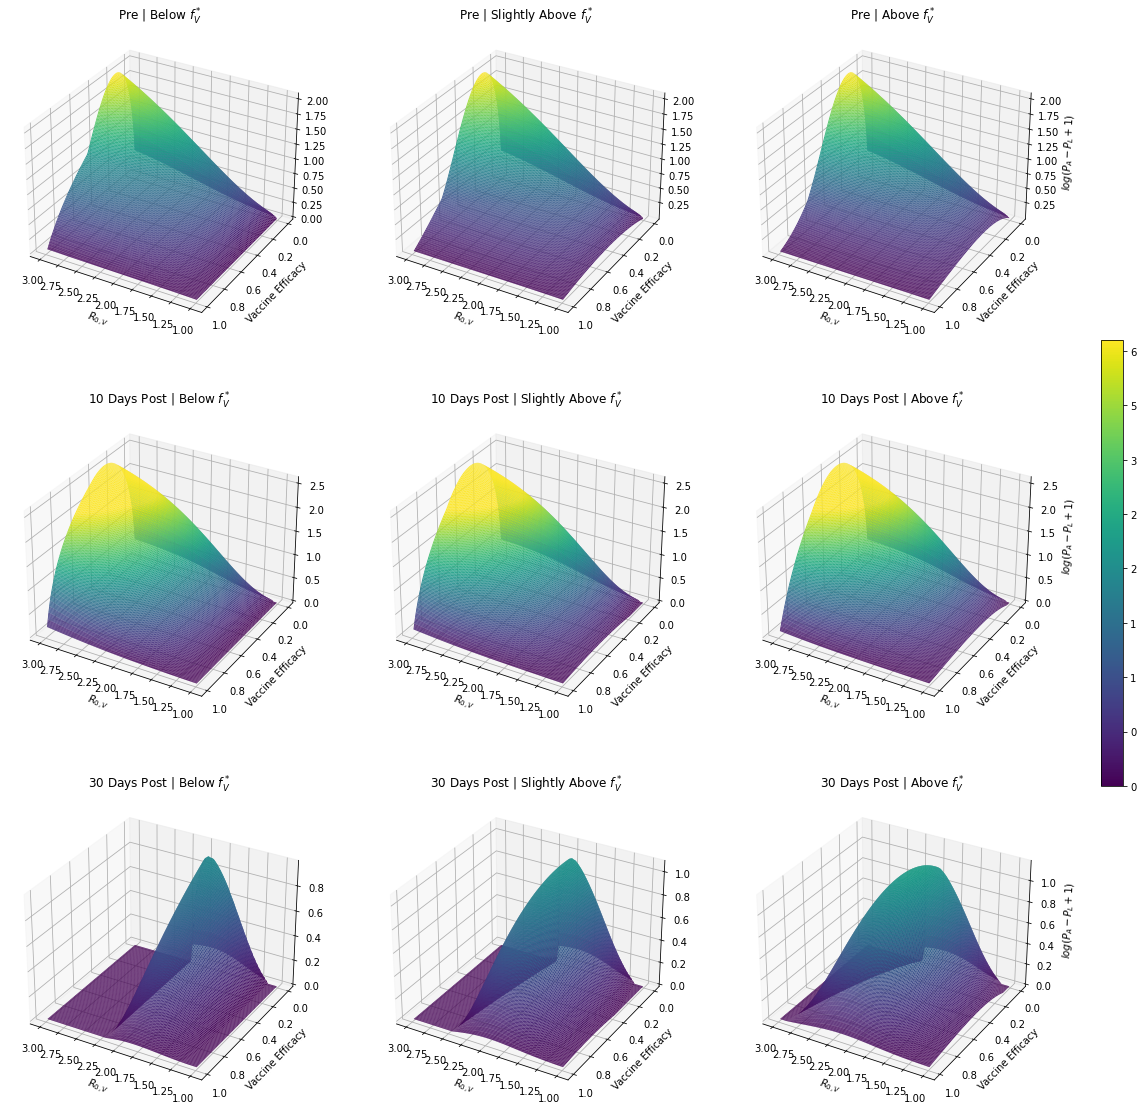

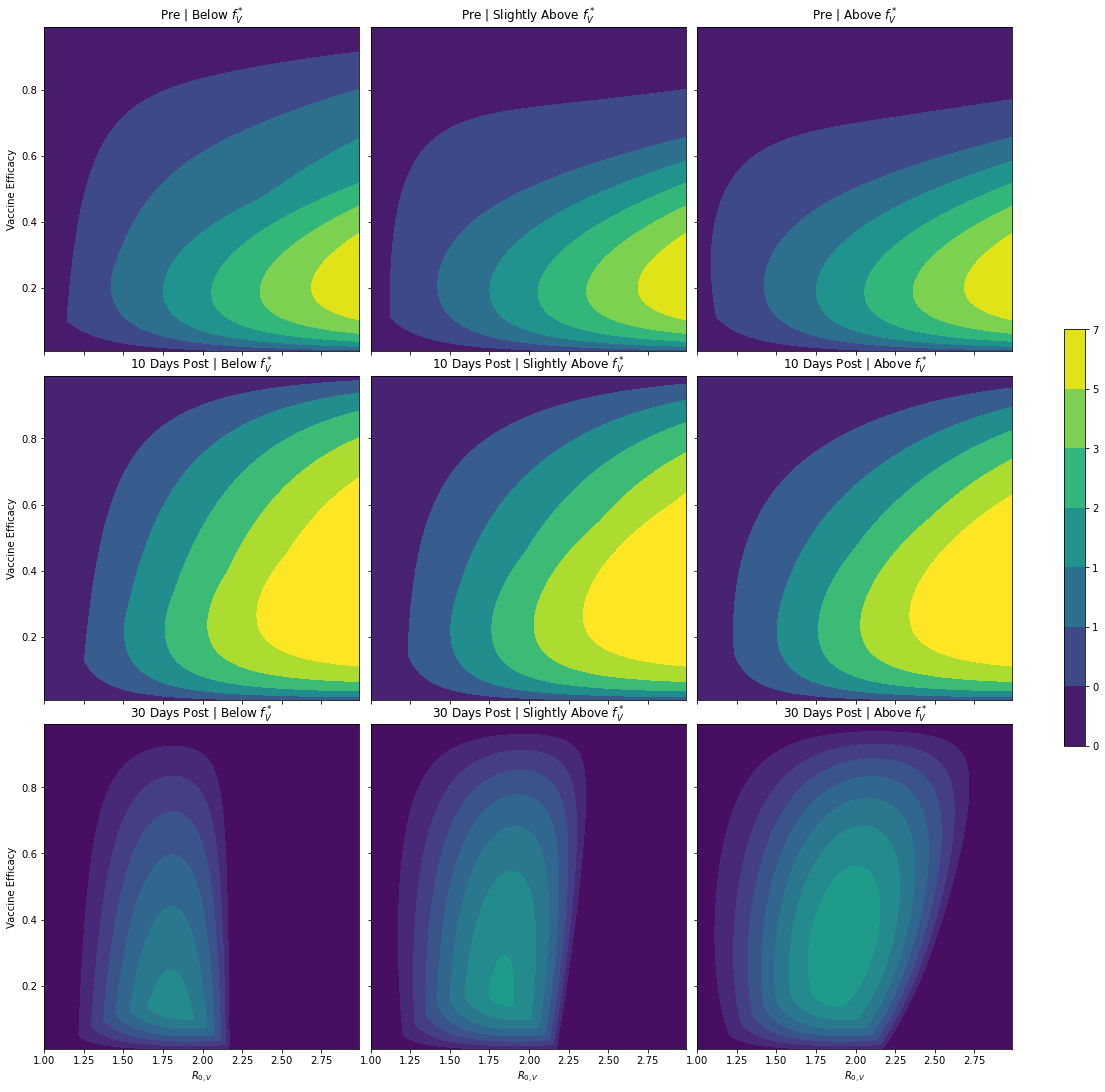

In [28]:
# set parameters
sigma = 1/4; gamma = 1/4
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = [s0, e0, i0, r0]
r0s = np.arange(1.0, 3.0, 0.01); epss = np.arange(0.01, 1.0, 0.01)

#t1 = np.linspace(0, 30, 31); t2 = np.linspace(0, 40, 41); t3 = np.linspace(0, 60, 61)
pre_df_30 = run_scenarios(y0, 30, -1, r0s, sigma, gamma, epss)
post10_df_30 = run_scenarios(y0, 40, 10, r0s, sigma, gamma, epss)
post30_df_30 = run_scenarios(y0, 60, 30, r0s, sigma, gamma, epss)

fig_3d = plot_scenarios(pre_df_30, post10_df_30, post30_df_30, dim=3)
fig_2d = plot_scenarios(pre_df_30, post10_df_30, post30_df_30, dim=2)

In [29]:
%store pre_df_30
%store post10_df_30
%store post30_df_30

Stored 'pre_df_30' (DataFrame)
Stored 'post10_df_30' (DataFrame)
Stored 'post30_df_30' (DataFrame)


# Measured 60 Days After Vaccination

/Users/dianelee/Documents/Github/vaccine-efficacy/VaccineEfficacy/utils/utils.py:405: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(np.round(np.exp(cblabels)-1).astype(int))


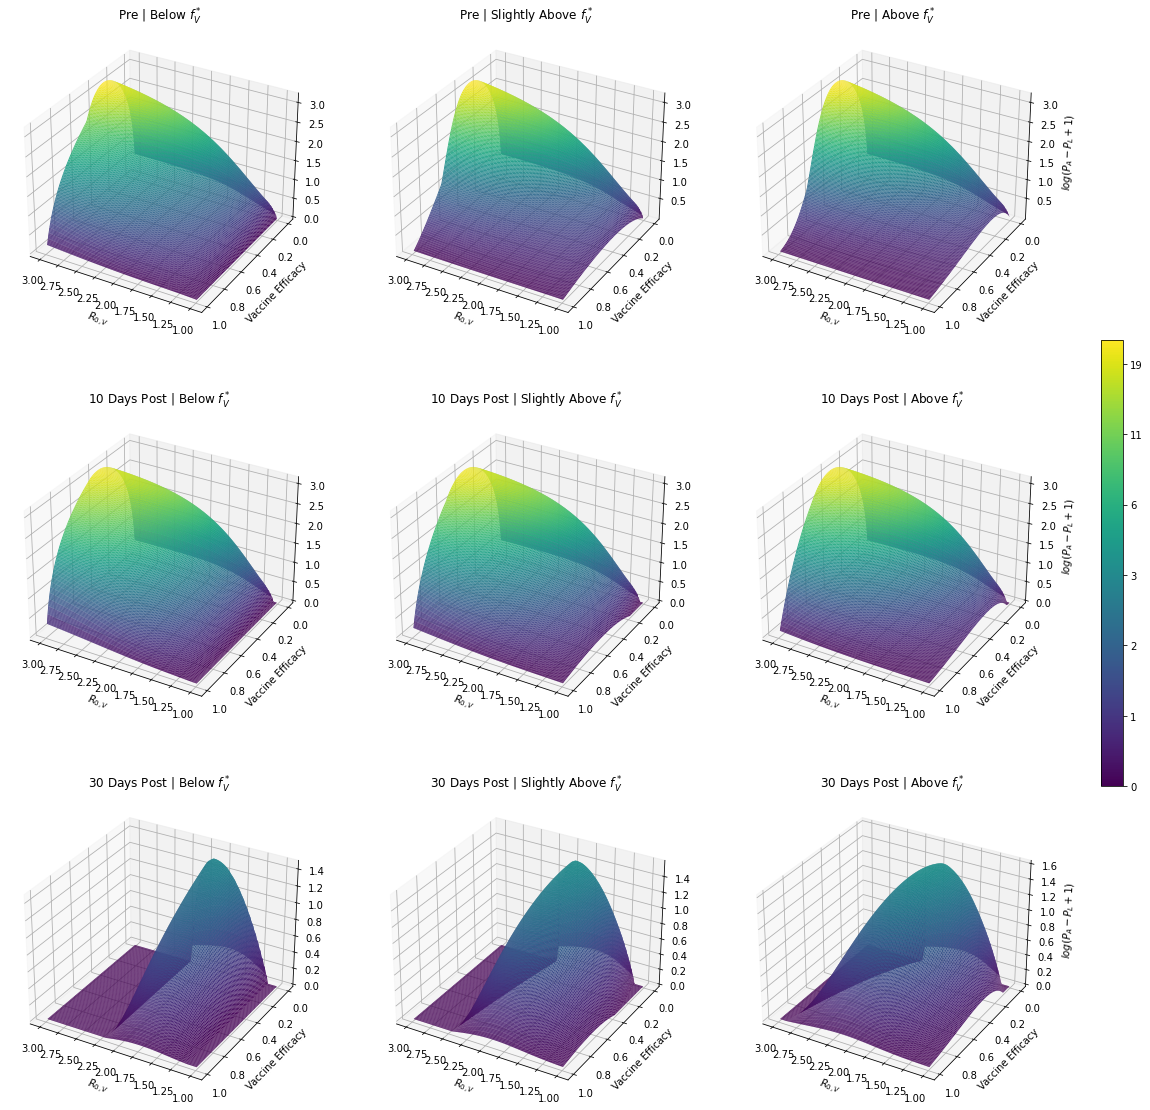

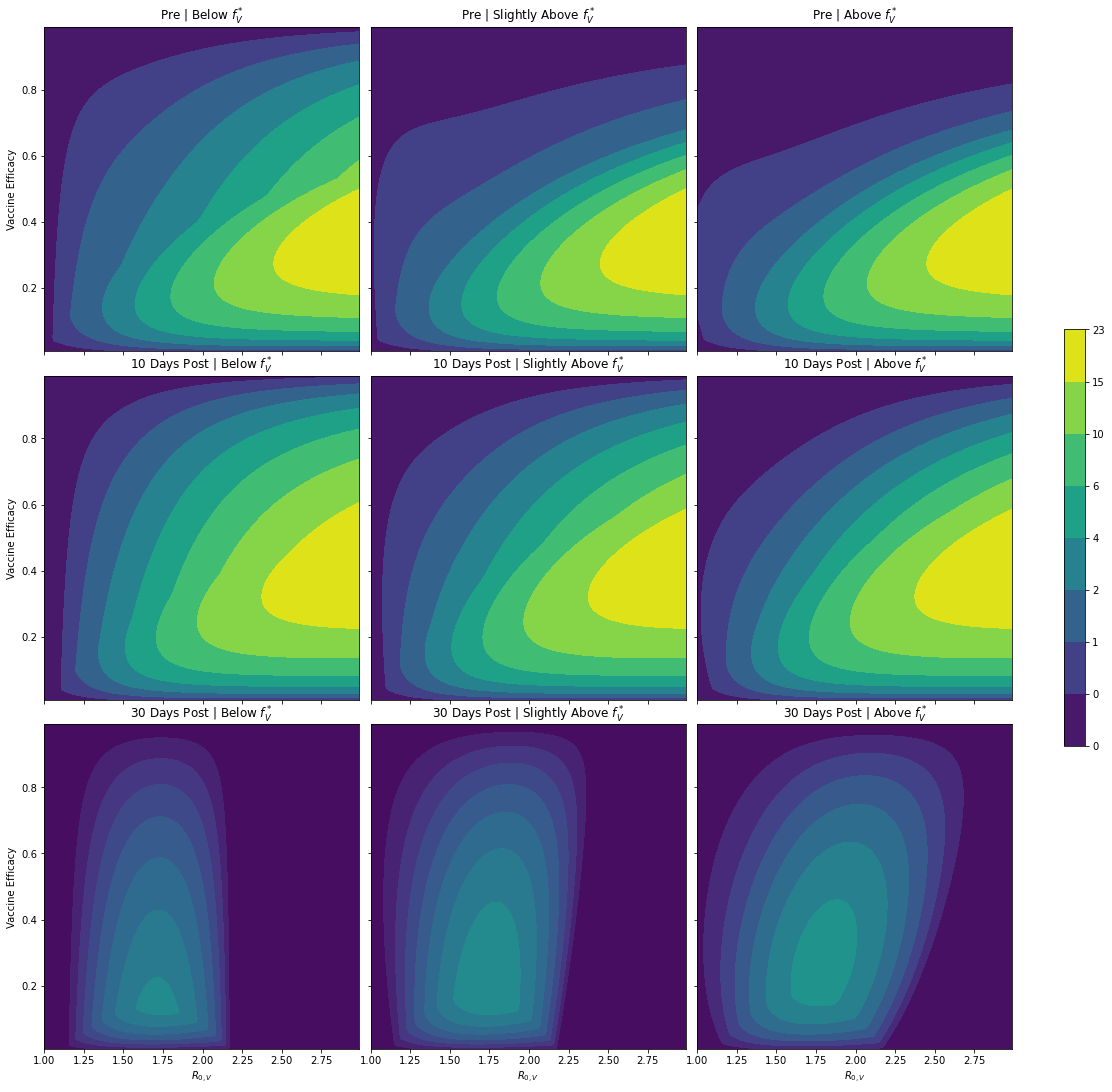

In [30]:
# set parameters
sigma = 1/4; gamma = 1/4
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = [s0, e0, i0, r0]
r0s = np.arange(1.0, 3.0, 0.01); epss = np.arange(0.01, 1.0, 0.01)

#t1 = np.linspace(0, 60, 61); t2 = np.linspace(0, 70, 71); t3 = np.linspace(0, 90, 91)
pre_df_60 = run_scenarios(y0, 60, -1, r0s, sigma, gamma, epss)
post10_df_60 = run_scenarios(y0, 70, 10, r0s, sigma, gamma, epss)
post30_df_60 = run_scenarios(y0, 90, 30, r0s, sigma, gamma, epss)

fig_3d = plot_scenarios(pre_df_60, post10_df_60, post30_df_60, dim=3)
fig_2d = plot_scenarios(pre_df_60, post10_df_60, post30_df_60, dim=2)

In [31]:
%store pre_df_60
%store post10_df_60
%store post30_df_60

Stored 'pre_df_60' (DataFrame)
Stored 'post10_df_60' (DataFrame)
Stored 'post30_df_60' (DataFrame)


# Measured 100 Days After Vaccination

/Users/dianelee/Documents/Github/vaccine-efficacy/VaccineEfficacy/utils/utils.py:405: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(np.round(np.exp(cblabels)-1).astype(int))


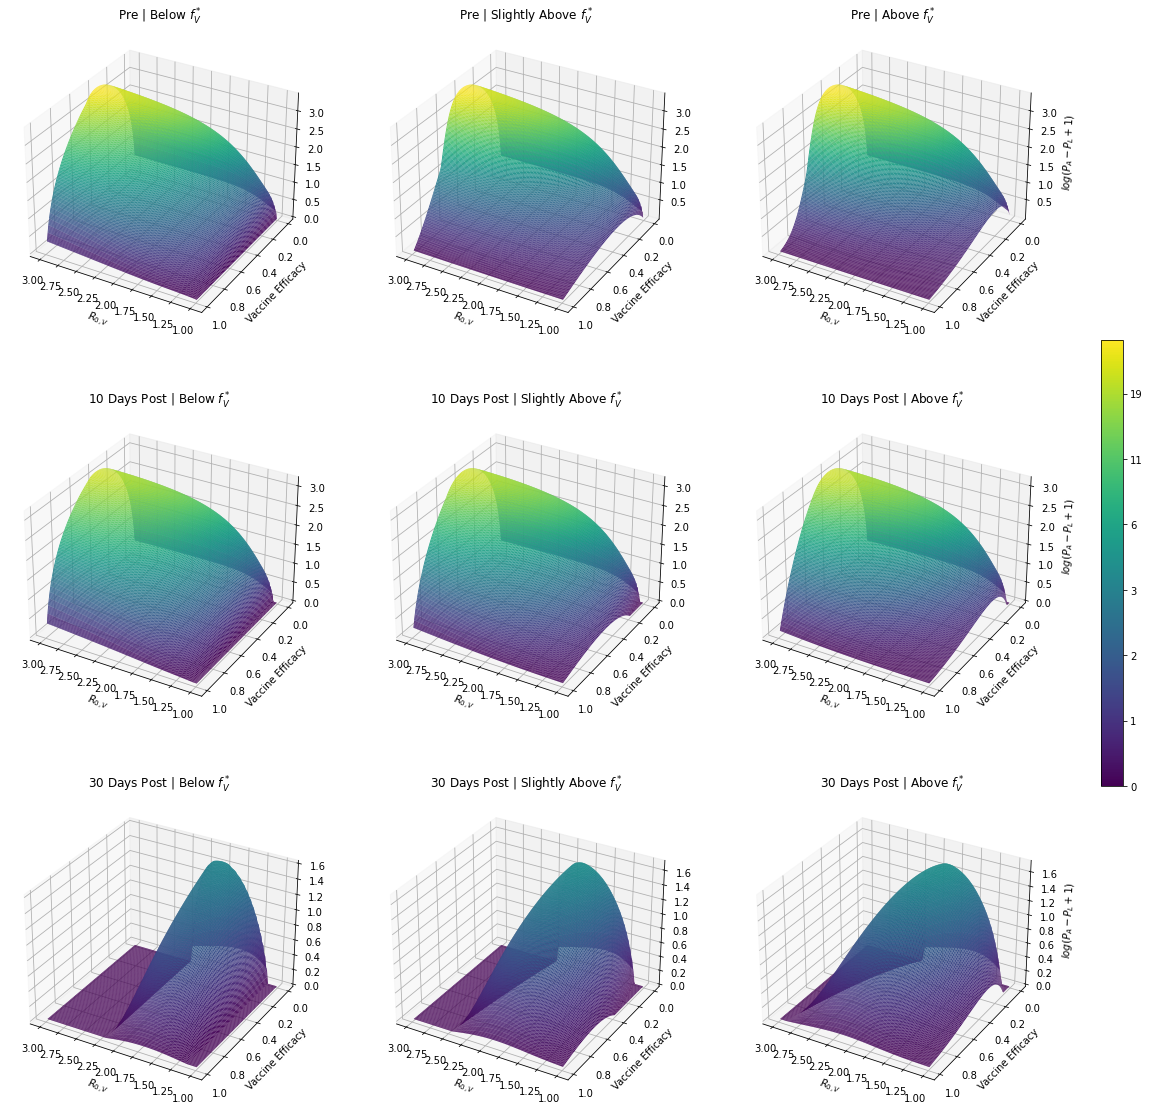

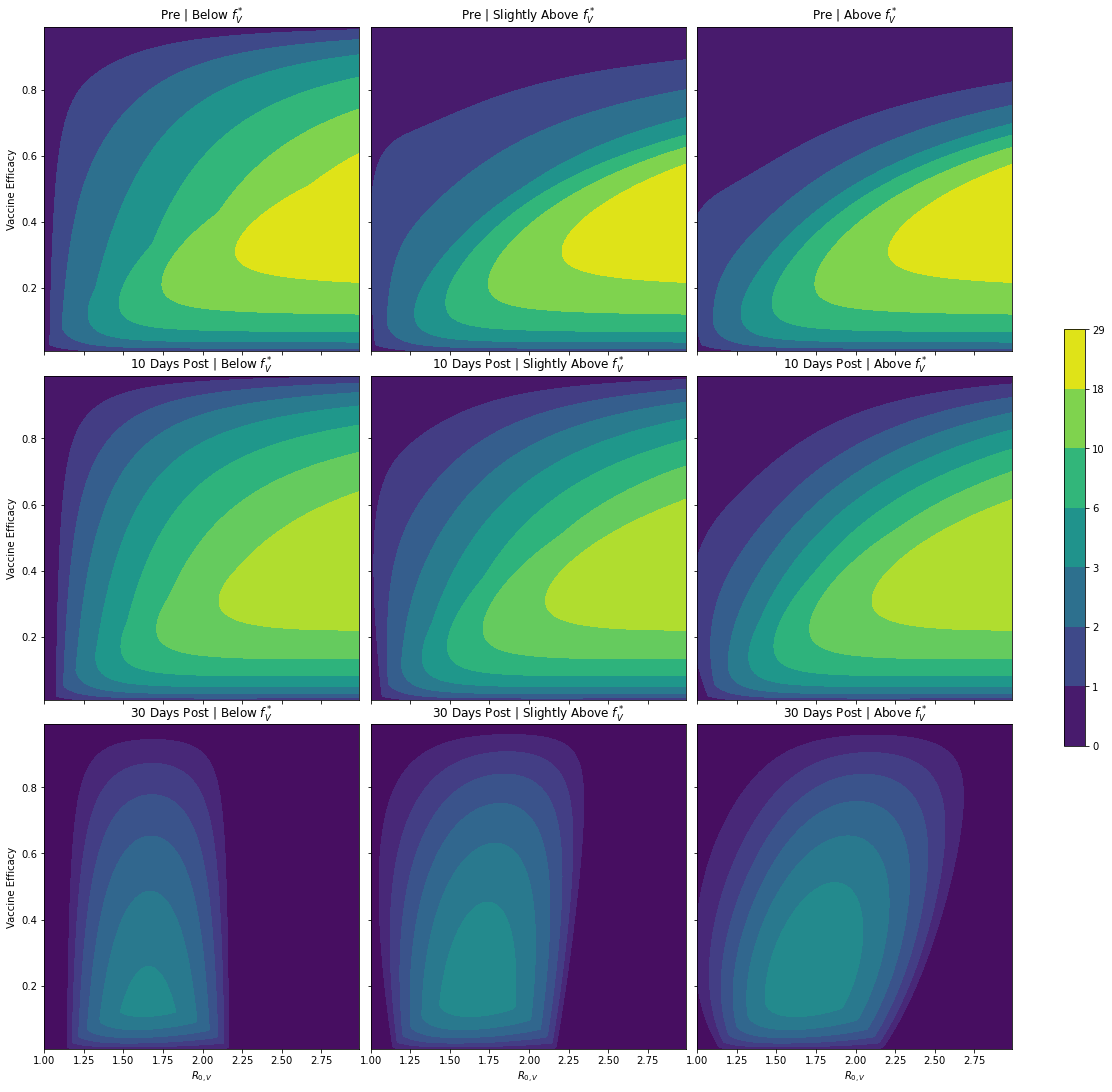

In [32]:
# set parameters
sigma = 1/4; gamma = 1/4
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = [s0, e0, i0, r0]
r0s = np.arange(1.0, 3.0, 0.01); epss = np.arange(0.01, 1.0, 0.01)

#t1 = np.linspace(0, 100, 101); t2 = np.linspace(0, 110, 111); t3 = np.linspace(0, 130, 131)
pre_df_100 = run_scenarios(y0, 100, -1, r0s, sigma, gamma, epss)
post10_df_100 = run_scenarios(y0, 110, 10, r0s, sigma, gamma, epss)
post30_df_100 = run_scenarios(y0, 130, 30, r0s, sigma, gamma, epss)

fig_3d = plot_scenarios(pre_df_100, post10_df_100, post30_df_100, dim=3)
fig_2d = plot_scenarios(pre_df_100, post10_df_100, post30_df_100, dim=2)

In [33]:
%store pre_df_100
%store post10_df_100
%store post30_df_100

Stored 'pre_df_100' (DataFrame)
Stored 'post10_df_100' (DataFrame)
Stored 'post30_df_100' (DataFrame)


# Measured 300 Days After Vaccination (End of Pandemic)

/Users/dianelee/Documents/Github/vaccine-efficacy/VaccineEfficacy/utils/utils.py:405: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(np.round(np.exp(cblabels)-1).astype(int))


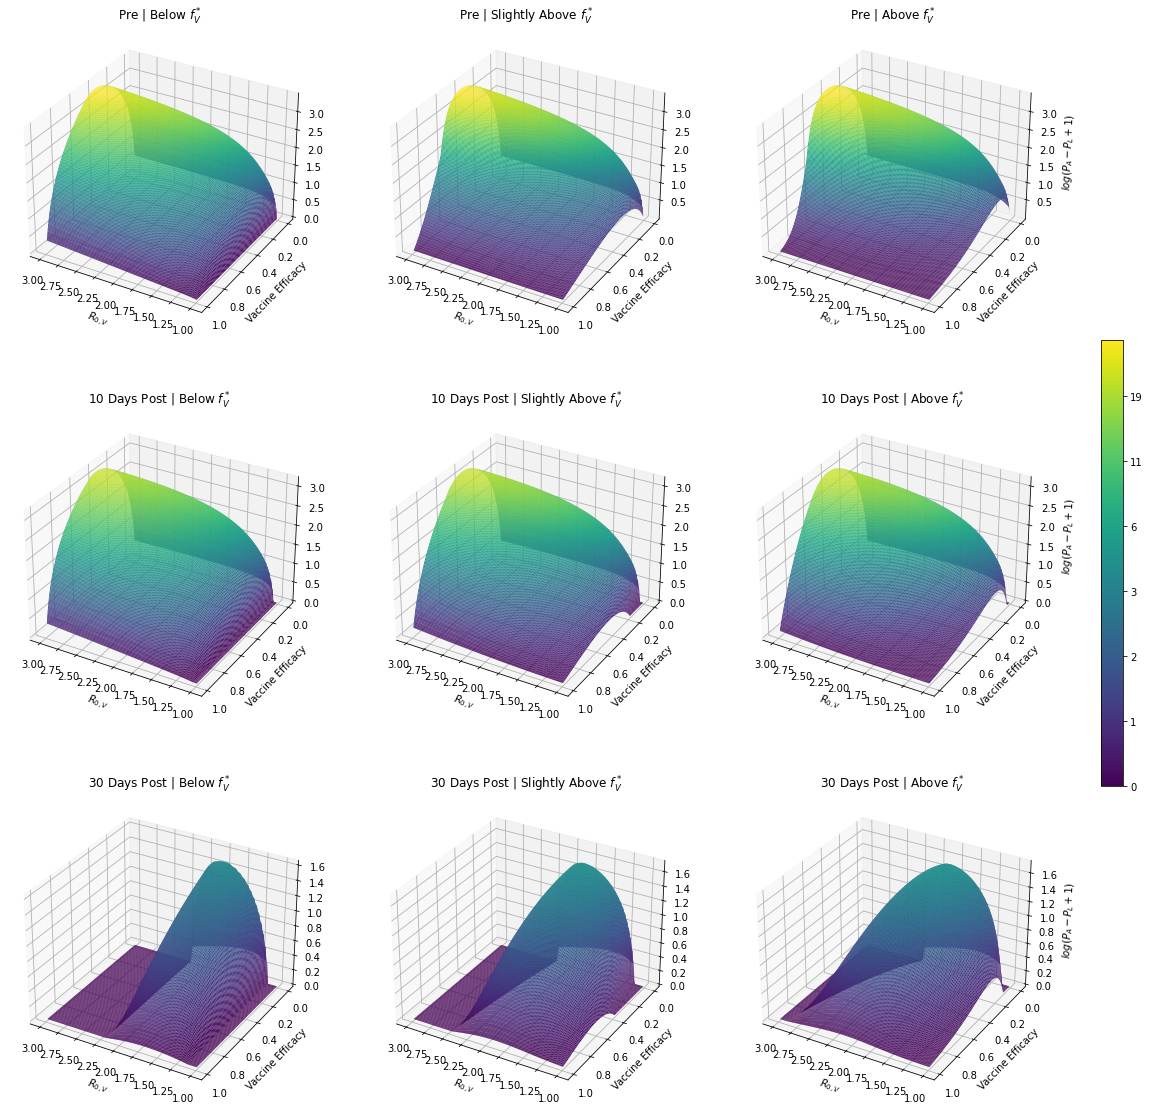

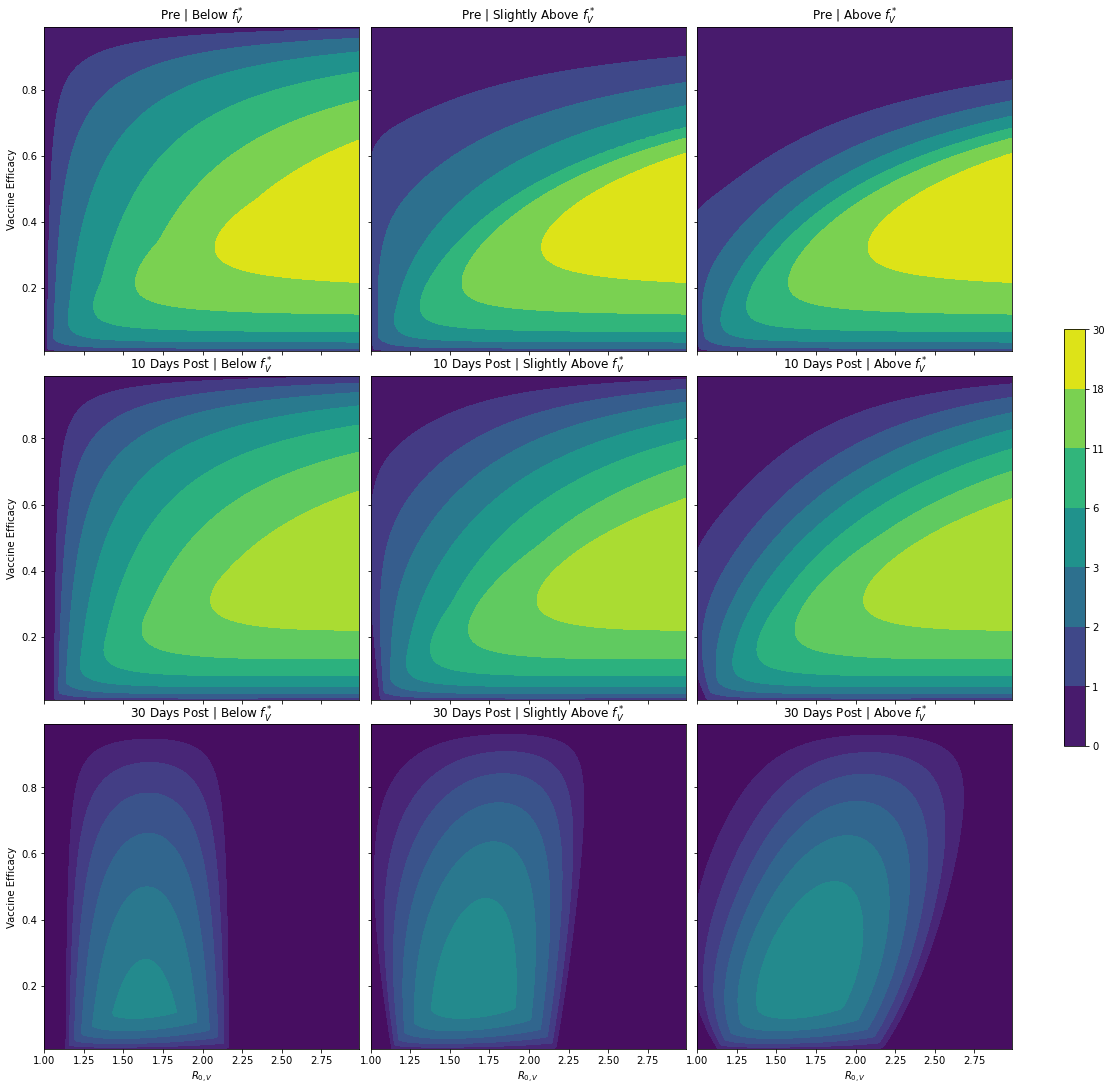

In [35]:
# set parameters
sigma = 1/4; gamma = 1/4; t = np.linspace(0, 300, 301)
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = [s0, e0, i0, r0]
r0s = np.arange(1.0, 3.0, 0.01); epss = np.arange(0.01, 1.0, 0.01)

pre_df_300 = run_scenarios(y0, 300, -1, r0s, sigma, gamma, epss)
post10_df_300 = run_scenarios(y0, 310, 10, r0s, sigma, gamma, epss)
post30_df_300 = run_scenarios(y0, 330, 30, r0s, sigma, gamma, epss)

fig_3d = plot_scenarios(pre_df_300, post10_df_300, post30_df_300, dim=3)
fig_2d = plot_scenarios(pre_df_300, post10_df_300, post30_df_300, dim=2)

In [36]:
%store pre_df_300
%store post10_df_300
%store post30_df_300

Stored 'pre_df_300' (DataFrame)
Stored 'post10_df_300' (DataFrame)
Stored 'post30_df_300' (DataFrame)
